# Testing GT catalogue load

Objectives:
    1. Test GT simulation waveform loaded through nrc-catalogue-tools.

## Load the library

In [1]:
import sys

#p1 = "/home/vaishakp/Codes/custom_libraries/nr-catalog-tools"
#libpath = '/mnt/pfs/vaishak.p/Projects/Codes/custom_libraries/nr-catalog-tools'
libpath = '/home/vaishakprasad/Documents/Codes/nr-catalog-tools'


if libpath not in sys.path:
    sys.path.append(libpath)

print(sys.path)

['/home/vaishakprasad/Documents/Codes/nr-catalog-tools/test/notebooks', '/home/vaishakprasad/Documents/Codes/config', '/home/vaishakprasad/Documents/Codes/waveformtools', '/home/vaishakprasad/Documents/Codes/qlmtools', '/home/vaishakprasad/Documents/Codes/nr-catalog-tools/test/notebooks', '/home/vaishakprasad/soft/anaconda3/envs/nrcat/lib/python310.zip', '/home/vaishakprasad/soft/anaconda3/envs/nrcat/lib/python3.10', '/home/vaishakprasad/soft/anaconda3/envs/nrcat/lib/python3.10/lib-dynload', '', '/home/vaishakprasad/soft/anaconda3/envs/nrcat/lib/python3.10/site-packages', '/home/vaishakprasad/Documents/Codes/nr-catalog-tools']


## Display the environment

In [2]:
%%bash
python --version
conda info --envs | grep '*'

Python 3.10.11
nrcat                 *  /home/vaishakprasad/soft/anaconda3/envs/nrcat


# Method I : through nr-catalogue-tools

In [3]:
import nrcatalogtools

No version information file '.version' found


In [4]:
import nrcatalogtools.lvc as lalutils

In [5]:
from nrcatalogtools.lvc import get_lal_mode_dictionary_from_lmax
#from nrcatalogtools.rit import RITCatalog
from nrcatalogtools.maya import MayaCatalog
from nrcatalogtools import utils
from nrcatalogtools.waveform import WaveformModes

In [6]:
import numpy as np
import sxs
import matplotlib.pyplot as plt

In [7]:
# View SXS cache
sxs.sxs_directory("cache")

PosixPath('/home/vaishakprasad/.cache/sxs')

### MAYA cat details

In [8]:
nrcatalogtools.utils.maya_catalog_info

{'cache_dir': PosixPath('/home/vaishakprasad/.cache/MAYA'),
 'url': 'https://raw.githubusercontent.com/cevans216/gt-waveform-catalog/master/h5files',
 'metadata_url': 'https://raw.githubusercontent.com/cevans216/gt-waveform-catalog/master/catalog-table.txt',
 'data_dir': PosixPath('/home/vaishakprasad/.cache/MAYA/data'),
 'metadata_dir': PosixPath('/home/vaishakprasad/.cache/MAYA/metadata'),
 'data_url': 'https://raw.githubusercontent.com/cevans216/gt-waveform-catalog/master/h5files'}

In [9]:
# Simulation name
sim_name = 'GT0001'

# Parameters
M = 40
D = 1000
inc = np.pi/6
coa_phase = np.pi/4
delta_t = 1./2048

## Load waveform

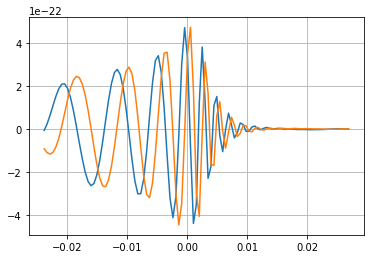

In [23]:
#sc = sxs.Catalog.load(download=True)
#rc = RITCatalog.load(verbosity=5, download=True)
mc = MayaCatalog.load(verbosity=5)

mwf = mc.get(sim_name)
hpc = mwf.get_td_waveform(total_mass=M, distance=D, inclination=inc,
                    coa_phase=coa_phase, delta_t=delta_t
                    )
hpc_pycbc = hpc # mwf.to_pycbc(hpc)
hp1, hc1 = hpc_pycbc.real(), hpc_pycbc.imag()

plt.plot(hp1.sample_times, hp)
plt.plot(hc1.sample_times, hc)
plt.grid()
plt.show()

In [11]:
import h5py

import gc
for obj in gc.get_objects():   # Browse through ALL objects
    print(obj)
    if isinstance(obj, h5py.File):   # Just HDF5 files
        try:
            obj.close()
            print('Closed', obj)
        except:
            pass # Was already closed


# Method II :

Using [the script](https://github.com/cevans216/gt-waveform-catalog/tree/master/scripts)

In [12]:
import lal

In [13]:
# Lal path
lal.__file__

'/home/vaishakprasad/soft/anaconda3/envs/nrcat/lib/python3.10/site-packages/lal/__init__.py'

## Original script, no changes

import h5py
import lal
import lalsimulation as lalsim
from pycbc import pnutils
from matplotlib import pyplot
import numpy

file = f'{fdir}/data/GT0001.h5'

f = h5py.File(file, 'r')

params = {}

# Extrinsic parameters:

params['f_lower'] = 20.0
params['mtotal'] = 150.0
params['inclination'] = 0.0
params['distance'] = 100.0

# Metadata parameters:

params['eta'] = f.attrs['eta']

params['mass1'] = pnutils.mtotal_eta_to_mass1_mass2(params['mtotal'], params['eta'])[0]
params['mass2'] = pnutils.mtotal_eta_to_mass1_mass2(params['mtotal'], params['eta'])[1]

params['spin1x'] = f.attrs['spin1x']
params['spin1y'] = f.attrs['spin1y']
params['spin1z'] = f.attrs['spin1z']
params['spin2x'] = f.attrs['spin2x']
params['spin2y'] = f.attrs['spin2y']
params['spin2z'] = f.attrs['spin2z']


params['coa_phase'] = f.attrs['coa_phase']

    
f.close()

#
dt = 1.0/4096.0

from pycbc.waveform import get_td_waveform

hp, hc = get_td_waveform(approximant='NR_hdf5',
                         numrel_data=file,
                         mass1=params['mass1'],
                         mass2=params['mass2'],
			 spin1x=params['spin1x'],
			 spin1y=params['spin1y'],
                         spin1z=params['spin1z'],
			 spin2x=params['spin2x'],
                         spin2y=params['spin2y'],
			 spin2z=params['spin2z'],
                         delta_t=dt,
                         f_lower=30.0,
                         inclination=params['inclination'],
                         coa_phase=params['coa_phase'],
                         distance=params['distance'])

#
t = numpy.array(range( len(hp) ) )*dt
pyplot.figure()
pyplot.plot( t, hp, color=[0,0.7071,1] )
pyplot.show()


Here, `coa_phase` is missing from h5 file's attributes. Correcting for this and loading the same simulation as in the catalogue load, 

In [16]:
def TransformSpinsNRtoLAL(nrSpin1, nrSpin2, n_hat, ln_hat):
    ''' Trnasform the spins of the NR simulation from the
    NR frame to the  frame.
    Parameters
    ----------
    nrSpin1, nrSpin2 : list
             A list of the components of the spins of the objects.
    nhat, ln_hat : list
             A list of the components of the unit vectors of the objects, 
             against which the components of the spins are specified.
    Returns
    -------
    S1, S2 : list
             The transformed spins in LAL frame.
    '''
    nrSpin1x, nrSpin1y, nrSpin1z = nrSpin1
    nrSpin2x, nrSpin2y, nrSpin2z = nrSpin2
    
    n_hat_x, n_hat_y, n_hat_z = n_hat
    ln_hat_x, ln_hat_y, ln_hat_z = ln_hat
        
    S1x = nrSpin1x * n_hat_x + nrSpin1y * n_hat_y + nrSpin1z * n_hat_z
    
    S1y = nrSpin1x * (-ln_hat_z * n_hat_y + ln_hat_y * n_hat_z)\
         + nrSpin1y * (ln_hat_z * n_hat_x - ln_hat_x * n_hat_z) \
         + nrSpin1z * (-ln_hat_y * n_hat_x + ln_hat_x * n_hat_y)
            
    S1z = nrSpin1x * ln_hat_x + nrSpin1y * ln_hat_y + nrSpin1z * ln_hat_z
  
    S2x = nrSpin2x * n_hat_x + nrSpin2y * n_hat_y + nrSpin2z * n_hat_z
    S2y = nrSpin2x * (-ln_hat_z * n_hat_y + ln_hat_y * n_hat_z) \
         + nrSpin2y * (ln_hat_z * n_hat_x - ln_hat_x * n_hat_z) \
         + nrSpin2z * (-ln_hat_y * n_hat_x + ln_hat_x * n_hat_y)
            
    S2z = nrSpin2x * ln_hat_x + nrSpin2y * ln_hat_y + nrSpin2z * ln_hat_z
    
    S1 = [S1x, S1y, S1z]
    S2 = [S2x, S2y, S2z]
    
    return S1, S2

In [17]:
%%bash
# Ensure threadsafe loading is off
export HDF5_USE_FILE_LOCKING='FALSE'

# LAL ROM dir
#export LAL_DATA_PATH='/home/vaishakprasad/soft/lalsuite/lalsuite-extra/data/lalsimulation' 
export LAL_DATA_PATH='/home/vaishakprasad/soft/lalsuite/lalsuite-extra/data/lalsimulation'
echo $LAL_DATA_PATH

/home/vaishakprasad/soft/lalsuite/lalsuite-extra/data/lalsimulation


In [42]:
from pycbc.waveform import td_approximants, fd_approximants

# List of td approximants that are available
#print(td_approximants())

if 'SEOBNRv4_ROM' not in td_approximants():
    print('Apx not loaded correctly!')

# List of fd approximants that are currently available
#print(fd_approximants())

In [19]:
%%bash
echo $LAL_DATA_PATH

/home/vaishakprasad/soft/lalsuite/lalsuite-extra/data/lalsimulation


Cannot find the attribute `coa_phase` in the file. Setting to 0.7853981633974483
Loading waveform


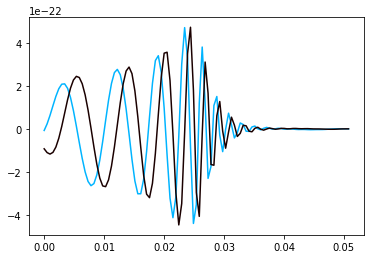

In [24]:
import h5py
import lal
import lalsimulation as lalsim
from pycbc import pnutils



fdir = nrcatalogtools.utils.maya_catalog_info['cache_dir']
file = f'{fdir}/data/{sim_name}.h5'


#file = f'/home/vaishakprasad/{sim_name}.h5'
# Check by changing spin by small amount
#dspins2x = np.linspace(-0.1, 0.1, 1000)
try:
    f.close()
except:
    pass

f = h5py.File(file, 'a')
if 'f_lower_at_1MSUN' not in list(f.attrs.keys()):
    
    f.attrs['f_lower_at_1MSUN'] = f_lower_at_1MSUN
    f.close()
else:
    f.close()
    
f = h5py.File(file, 'r')
    
#print(f.attrs.keys())
#print(f.keys())
params = {}

# Extrinsic parameters:
f_lower = 20
f_lower_at_1MSUN = f_lower/M



params['f_lower'] = f_lower
params['mtotal'] = M#150.0
params['inclination'] = inc#0.0
params['distance'] = D#100.0

# Metadata parameters:

params['eta'] = f.attrs['eta']

params['mass1'] = pnutils.mtotal_eta_to_mass1_mass2(params['mtotal'], params['eta'])[0]
params['mass2'] = pnutils.mtotal_eta_to_mass1_mass2(params['mtotal'], params['eta'])[1]

# BH1 spins
params['spin1x'] = f.attrs['spin1x']
params['spin1y'] = f.attrs['spin1y']
params['spin1z'] = f.attrs['spin1z']


# BH2 spins

params['spin2x'] = f.attrs['spin2x']
params['spin2y'] = f.attrs['spin2y']
params['spin2z'] = f.attrs['spin2z']


# Spin unit vectors

params['nhat'] = [f.attrs['nhatx'], f.attrs['nhaty'], f.attrs['nhatz']]
params['lnhat'] = [f.attrs['LNhatx'], f.attrs['LNhaty'], f.attrs['LNhatz']]


# Check for coa_phase, else use the phase from nr cat load.
try:
    params['coa_phase'] = f.attrs['coa_phase']
except:
    print(f'Cannot find the attribute `coa_phase` in the file. Setting to {coa_phase}')
    #raise AttributeError('Cannot find the attribute `coa_phase` in the file')
    params['coa_phase']=coa_phase

# Transform spins

# NR frame
s1 = [params['spin1x'], params['spin1y'], params['spin1z']]
s2 = [params['spin2x'], params['spin2y'], params['spin2z']]

# LAL frame
S1, S2 = TransformSpinsNRtoLAL(s1, s2, params['nhat'], params['lnhat'])

from pycbc.waveform import get_td_waveform


print('Loading waveform')
hp2, hc2 = get_td_waveform(approximant='NR_hdf5',
                         numrel_data=file,
                         mass1=params['mass1'],
                         mass2=params['mass2'],
                         spin1x=S1[0],
                         spin1y=S1[1],
                         spin1z=S1[2],
                         spin2x=S2[0],
                         spin2y=S2[1],
                         spin2z=S2[2],
                         delta_t=delta_t,
                         f_lower=f_lower,
                         inclination=params['inclination'],
                         coa_phase=params['coa_phase'],
                         distance=params['distance'])

#
t = np.array(range( len(hp) ) )*delta_t

#pyplot.figure()
plt.plot(t, hp2, color=[0,0.7071,1])
plt.plot(t, hc2, color=[0.1,0,0])
plt.show()
f.close()

In [28]:
mloc2 = np.argmax(hp2**2 + hc2**2)

In [29]:
t-=t[mloc2]

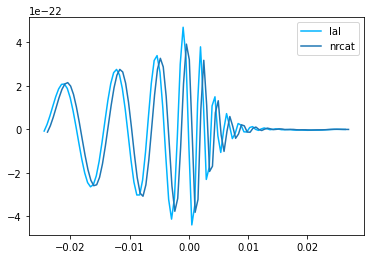

In [32]:
plt.plot(t, hp2, color=[0,0.7071,1], label='lal')
#plt.plot(t, hc2, color=[0.1,0,0])
plt.plot(hp1.sample_times, hp1, label='nrcat')
#plt.plot(hc1.sample_times, hc1)
plt.legend()
plt.show()

In [33]:
h1 = hp1 + 1j*hc1
h2 = hp2 + 1j*hc2

In [36]:
np.absolute(np.array(h2/h1))

array([0.99273613, 0.99061303, 0.99097692, 0.99134463, 0.99087007,
       0.99136259, 0.99291806, 0.99444007, 0.99514006, 0.99476788,
       0.99464956, 0.99507156, 0.99552162, 0.99757324, 1.00198818,
       1.00808946, 1.01519975, 1.02130802, 1.02422379, 1.02343416,
       1.01871894, 1.01142008, 1.0043216 , 0.99981122, 0.99873888,
       1.00022637, 1.00220624, 1.00230971, 0.99894052, 0.99321825,
       0.98852869, 0.98881888, 0.99609865, 1.00840499, 1.02048066,
       1.02740217, 1.02917684, 1.03159302, 1.04091369, 1.05705975,
       1.07256795, 1.07786122, 1.07218604, 1.07062477, 1.09042481,
       1.12655613, 1.15355925, 1.1631783 , 1.17292151, 1.17697391,
       1.14374084, 1.11117611, 1.13569662, 1.16267177, 1.19082043,
       1.19874022, 1.13696771, 1.14248218, 1.18637139, 1.15630645,
       1.09516149, 1.05085294, 1.15481805, 1.22442411, 1.11410132,
       1.01346438, 1.08961945, 1.21215124, 1.11883955, 0.93633612,
       1.06066921, 1.26614819, 1.17817254, 0.89916572, 0.94555